In [ ]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image
from socket import timeout
from google.colab import files
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler, SequentialSampler
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import Sampler
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

--2024-02-02 08:35:46--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  31.1MB/s    in 19s     

2024-02-02 08:36:05 (28.1 MB/s) - ‘train.zip’ saved [562348083/562348083]

--2024-02-02 08:36:11--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===============

In [ ]:
train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU is available")
else:
  device = torch.device("cpu")
  print("GPU is not available")

GPU is available


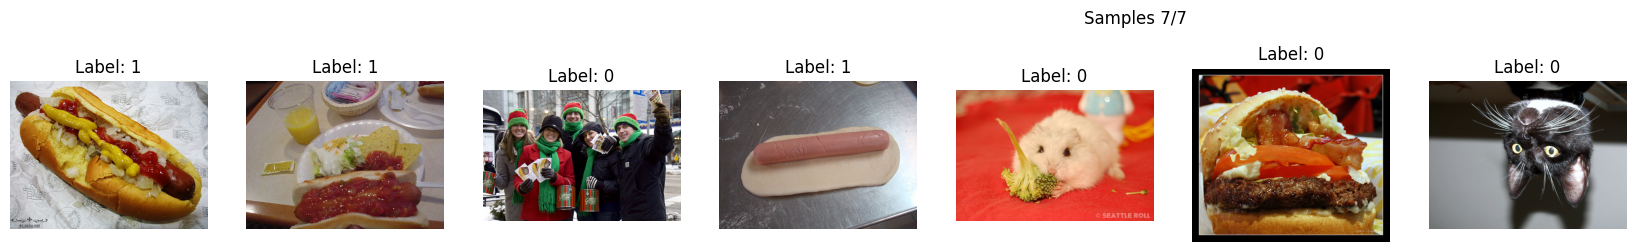

In [ ]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        self.file_list = os.listdir(folder)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_name = self.file_list[index]
        img_path = os.path.join(self.folder, img_name)
        img = Image.open(img_path).convert('RGB')                        # Convert to RGB (if the image is in a different format)
        img_id = os.path.splitext(img_name)[0]
        if img_name.startswith(('frankfurter', 'chili-dog', 'hotdog')):  # Determining the label depending on the file name
            y = 1                                                        # Positive label
        else:
            y = 0                                                        # Negative label

        if self.transform:                                               # Executing transformation, if it's given
            img = self.transform(img)

        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10, labels:list=None):
    plt.figure(figsize=(count*3,3))                                       # visualize random 10 samples (or given number of samples)
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))
    for i, index in enumerate(display_indices):
        x, y, _ = dataset[index]
        if labels:
          y = labels[i]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.axis('off')

orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

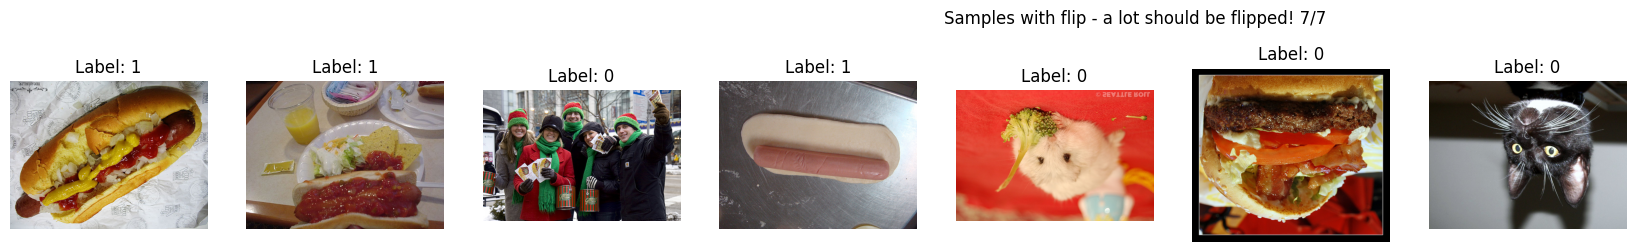

In [ ]:
# Let's make sure transforms work, and labels are displayed correctly
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.7))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

### We use augmentation for train-data, because:

1) We don't have much data, and we add objects to the train-data this way.

2) Augmentation helps us with overfitting, which happens, when we have not much data.

In [ ]:
# First, let's load the dataset
train_dataset = HotdogOrNotDataset(train_folder,
                       transform=transforms.Compose([
                           transforms.RandomHorizontalFlip(),                # Using some augmentation for only train dataset
                           transforms.RandomVerticalFlip(),
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Use mean and std for pretrained models
                                 std=[0.229, 0.224, 0.225])
                       ])
                      )

test_dataset = HotdogOrNotDataset(test_folder,
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Use mean and std for pretrained models
                                 std=[0.229, 0.224, 0.225])
                       ])
                      )

In [ ]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(validation_fraction * data_size)
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Function for training neural network models, which gives us loss-function metric for the train-data, and accuracy metric for validation-data and train-data, and save it in lists for every epoch.

Optionally, you can set f1-score metric, if we have a very strong imbalance in classes, that's why accuracy could be bad metric.

Also we can decrease learning rate, if the loss-function don't decrease for specified numbers of epochs in the "patience" parameter. For early stopping opportunity we have "patience_f1" parameter, which will stop learning, if f1-score don't improve for specified number of epochs in "patience_f1" parameter.

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, patience=10, patience_f1=None, val_f1_history:bool=None):
    loss_history = []
    train_history = []
    val_history = []
    val_history_f1 = []

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, threshold=0.00001)      # learning rate scheduler
    best_val_f1 = 0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()                                                                          # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        if val_f1_history:                                                                       # Optional f1-score metric bloch
          val_f1 = compute_f1(model, val_loader)
          val_history_f1.append(val_f1)

        torch.save({                                                                             #Saving weights after each batch
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': ave_loss,
        }, f'/content/gdrive/MyDrive/hotdog_epochs/model_checkpoint_epoch_idx_{epoch}.pth')

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        scheduler.step(ave_loss)
        print("Learning rate:", optimizer.param_groups[0]['lr'])

        if val_f1_history:                                                                       # Optional f1-score metric print
          print("Average loss: %f, Train accuracy: %f, Val accuracy: %f, Val f1-score: %f" % (ave_loss, train_accuracy, val_accuracy, val_f1))
        else:                                                                                    # Without optional f1-score metric print
          print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

        if patience_f1:                                                                          # Optional f1 early stopping opportunity block
          val_f1 = compute_f1(model, val_loader)
          if val_f1 > best_val_f1:
              best_val_f1 = val_f1
              epochs_without_improvement = 0
          else:
              epochs_without_improvement += 1
          print("F1 score = ", val_f1)

          if epochs_without_improvement >= patience_f1:
              print(f"Early stopping at epoch {epoch + 1} after no improvement for {epochs_without_improvement} epochs.")
              break                                                                              # The end early stopping opportunity block

    if val_f1_history:
      return loss_history, train_history, val_history, val_history_f1
    else:
      return loss_history, train_history, val_history

def compute_accuracy(model, loader, correct_label:int=None):                                     # function for compute accuracy metric
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1

    Note: We need the "correct_label" parameter in situations, when
    we have a model with classes more than 2, and would like
    to check it on a dataset with 2 classes. In these cases
    we should specify the label that we are interested in.
    """
    model.eval()
    total_samples_valid = 0
    correct_samples = 0
    for x,y,_ in loader:
      x = x.to(device)
      y = y.to(device)
      prediction = model(x)
      total_samples_valid += y.shape[0]
      _, indices = torch.max(prediction, 1)

      if correct_label:                                                                          # Optional block for "correct_label" block
        indices = torch.Tensor([1 if int(indices[i])==correct_label else 0 for i in range(len(indices))]).to(device)

      correct_samples += torch.sum(indices == y)
    accuracy = float(correct_samples) / total_samples_valid
    return accuracy

The function is written for a augmented data, which gives a random dataset variant, what may gives a various f1-score. That's why we need some epochs, that we have more accurate f1-score. We train a dataset by number of epochs in the "num_epochs" parameter, then average it, and get a f1-score more correctly. As well it let us train better, when "train_model()" function has the definite "patience_f1" parameter.

If we need to test any model without augmented data, we can define "num_epochs" parameter to 1.

In [ ]:
def compute_f1(model, loader, num_epochs=5):                                                    # function for compute f1-score
    model.eval()
    f1_history = []

    for epoch in range(num_epochs):
      ground_truths = np.array([])
      predictions = np.array([])

      for x,y,_ in loader:
        x = x.to(device)
        y = y.to(device)
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        ground_truth = y.cpu().numpy()
        ground_truths = np.concatenate([ground_truths, ground_truth])
        prediction = indices.cpu().numpy()
        predictions = np.concatenate([predictions, prediction])

      f1 = f1_score(ground_truths, predictions)
      f1_history.append(f1)

    f1_mean = np.mean(f1_history)
    return f1_mean

In [ ]:
def load_imagenet_classes():                            # Gives us a dictionary with indices keys and name value
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    class_index_to_name = { int(k): v[-1] for k, v in classes.items()}
    return class_index_to_name

imagenet_classes = load_imagenet_classes()

In [ ]:
check_indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)          # indices for resnet18 model checking
check_dataset = [train_dataset[i] for i in check_indices]                                  # list of objects for model checking
check_loader = torch.utils.data.DataLoader(check_dataset, batch_size=len(check_indices))

correct_label = {"hotdog":i for i in range(len(imagenet_classes)) if imagenet_classes[i]=="hotdog"}
correct_label["hotdog"]

934

Val accuracy: 0.905435


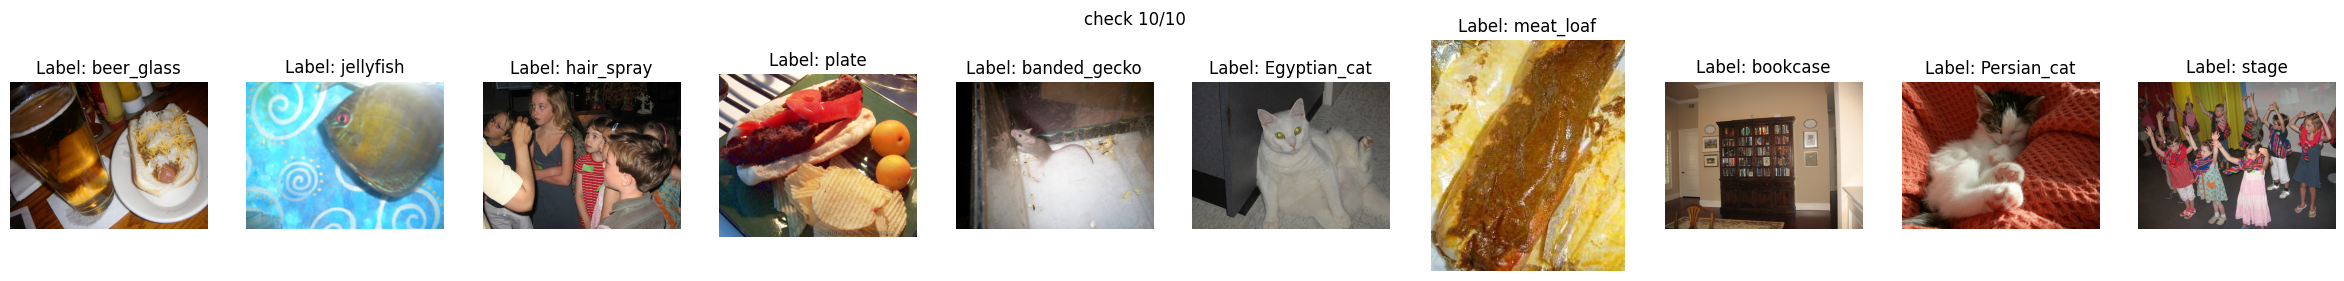

In [ ]:
model = models.resnet18(pretrained=True).to(device)
model.eval()

for x,_,_ in check_loader:                                                                  # checking resnet18 model by 10 random objects
  x = x.to(device)
  prediction = model(x)
  _, check_indices_max = torch.max(prediction, 1)
check_name_classes = [imagenet_classes[i] for i in check_indices_max.tolist()]
print("Val accuracy: %f" % compute_accuracy(model, val_loader,correct_label=correct_label["hotdog"]))
visualize_samples(orig_dataset, check_indices, "check", labels=check_name_classes)

Next we train 2 models, in the first case we train only the last fully-connected layer, and in the second case we try to train entire model. In the second case all layers except the fully-connected layer have learning rate less, than fully-connected has, because the model has common training patterns on imagenet pictures, and we don't want to overfit the model. Let's compare the quality and working time of the 2 models.

In [ ]:
%%time
model = models.resnet18(pretrained=True)                                                    # first model
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
parameters = model.fc.parameters()
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history, val_f1_history = train_model(model, train_loader, val_loader, loss, optimizer, 10,
                                                                       val_f1_history=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Learning rate: 0.001
Average loss: 0.381884, Train accuracy: 0.830573, Val accuracy: 0.913043, Val f1-score: 0.858108
Learning rate: 0.001
Average loss: 0.238458, Train accuracy: 0.906055, Val accuracy: 0.915217, Val f1-score: 0.891156
Learning rate: 0.001
Average loss: 0.204435, Train accuracy: 0.919359, Val accuracy: 0.926087, Val f1-score: 0.876761
Learning rate: 0.001
Average loss: 0.195569, Train accuracy: 0.928319, Val accuracy: 0.931522, Val f1-score: 0.881834
Learning rate: 0.001
Average loss: 0.184868, Train accuracy: 0.930491, Val accuracy: 0.933696, Val f1-score: 0.896057
Learning rate: 0.001
Average loss: 0.183473, Train accuracy: 0.927505, Val accuracy: 0.935870, Val f1-score: 0.877778
Learning rate: 0.001
Average loss: 0.175807, Train accuracy: 0.936193, Val accuracy: 0.941304, Val f1-score: 0.883212
Learning rate: 0.001
Average loss: 0.170292, Train accuracy: 0.932935, Val accuracy: 0.931522, Val f1-score: 0.880435
Learning rate: 0.001
Average loss: 0.170282, Train accur

In [ ]:
%%time
model = models.resnet18(pretrained=True)                                                    # Second model

num_ftrs = model.fc.in_features                                                             # Replace the last layer
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

learning_rates = {'fc': 0.001, 'other': 0.0001}
other_parameters = [param for name, param in model.named_parameters() if 'fc' not in name]

parameters = [                                                                              # Create list of dictionaries for optimizer
    {'params': model.fc.parameters(), 'lr': learning_rates['fc']},                          # New layer
    {'params': other_parameters, 'lr': learning_rates['other']}                             # Others
]
optimizer = optim.SGD(parameters, momentum=0.9)

loss = nn.CrossEntropyLoss()
loss_history, train_history, val_histor, val_f1_history_all_params = train_model(model, train_loader, val_loader, loss, optimizer, 10,
                                                                        val_f1_history=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Learning rate: 0.001
Average loss: 0.363165, Train accuracy: 0.833831, Val accuracy: 0.907609, Val f1-score: 0.845018
Learning rate: 0.001
Average loss: 0.213334, Train accuracy: 0.916373, Val accuracy: 0.930435, Val f1-score: 0.873606
Learning rate: 0.001
Average loss: 0.192929, Train accuracy: 0.925333, Val accuracy: 0.914130, Val f1-score: 0.852772
Learning rate: 0.001
Average loss: 0.174663, Train accuracy: 0.932392, Val accuracy: 0.939130, Val f1-score: 0.906526
Learning rate: 0.001
Average loss: 0.157739, Train accuracy: 0.940266, Val accuracy: 0.939130, Val f1-score: 0.882459
Learning rate: 0.001
Average loss: 0.159668, Train accuracy: 0.939452, Val accuracy: 0.946739, Val f1-score: 0.908146
Learning rate: 0.001
Average loss: 0.149597, Train accuracy: 0.942981, Val accuracy: 0.939130, Val f1-score: 0.888889
Learning rate: 0.001
Average loss: 0.147312, Train accuracy: 0.944339, Val accuracy: 0.946739, Val f1-score: 0.900181
Learning rate: 0.001
Average loss: 0.142106, Train accur

As we can see, when we use all the weights for training, it's not much longer with our small dataset, than we use only fully-connected layer for training. Let's create the final model with different learning rates, and "Adam" optimizer, and included "patience" and "patience_f1" optimizing features, described when creating this function.

In [ ]:
%%time
model = models.resnet18(pretrained=True)                                                # Third model
batch_size = 64

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

learning_rates = {'fc': 0.01, 'other': 0.0001}
other_parameters = [param for name, param in model.named_parameters() if 'fc' not in name]

parameters = [
    {'params': model.fc.parameters(), 'lr': learning_rates['fc']},
    {'params': other_parameters, 'lr': learning_rates['other']}
]

optimizer = optim.Adam(parameters)                                                      # Change the optimizer from SGD to Adam

loss = nn.CrossEntropyLoss()
loss_history, train_history, val_history, val_f1_history_final = train_model(model, train_loader, val_loader, loss, optimizer,
                                                                             num_epochs = 100, patience=3, patience_f1=20, val_f1_history=True)

In [ ]:
df = pd.DataFrame(val_f1_history_final, columns=['val_f1_history'])                       # Create the DataFrame from list
df.to_csv('/content/gdrive/MyDrive/hotdog_epochs/val_f1_history_final.csv', index=True)   # Save the DataFrame to a CSV file in Google Drive

In [ ]:
best_epoch_idx = 46                                                                       # Find the best index from the list
print("Best epoch: %d" %(best_epoch_idx + 1))
print("Best f1-score: %f, Val accuracy: %f" %(val_f1_history_final[best_epoch_idx], val_history[best_epoch_idx]))

Best epoch: 47
Best f1-score: 0.932303, Val accuracy: 0.958696


In [ ]:
best_model = models.resnet18()                                                             # Final model

num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, 2)
                                                                                           # Loading best parameters with best f1-score
checkpoint = torch.load(f'/content/gdrive/MyDrive/hotdog_epochs/model_checkpoint_epoch_idx_{best_epoch_idx}.pth')
best_model.load_state_dict(checkpoint['model_state_dict'])

best_model.to(device)

In [ ]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

In [ ]:
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset

    Returns:
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval()

    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=sampler)

    predictions = np.array([])
    ground_truths = np.array([])

    for x, y, _ in loader:
        x = x.to(device)
        y = y.to(device)
        prediction = model(x)
        _, prediction_indices = torch.max(prediction, 1)
        prediction_indices = prediction_indices.cpu().numpy()
        y = y.cpu().numpy()

        predictions = np.concatenate([predictions, prediction_indices])
        ground_truths = np.concatenate([ground_truths, y])

    return predictions.astype(int), ground_truths.astype(int)

predictions, gt = evaluate_model(best_model, train_dataset, val_indices)

Number of false-negative samples = 22
Number of false-positive samples = 18


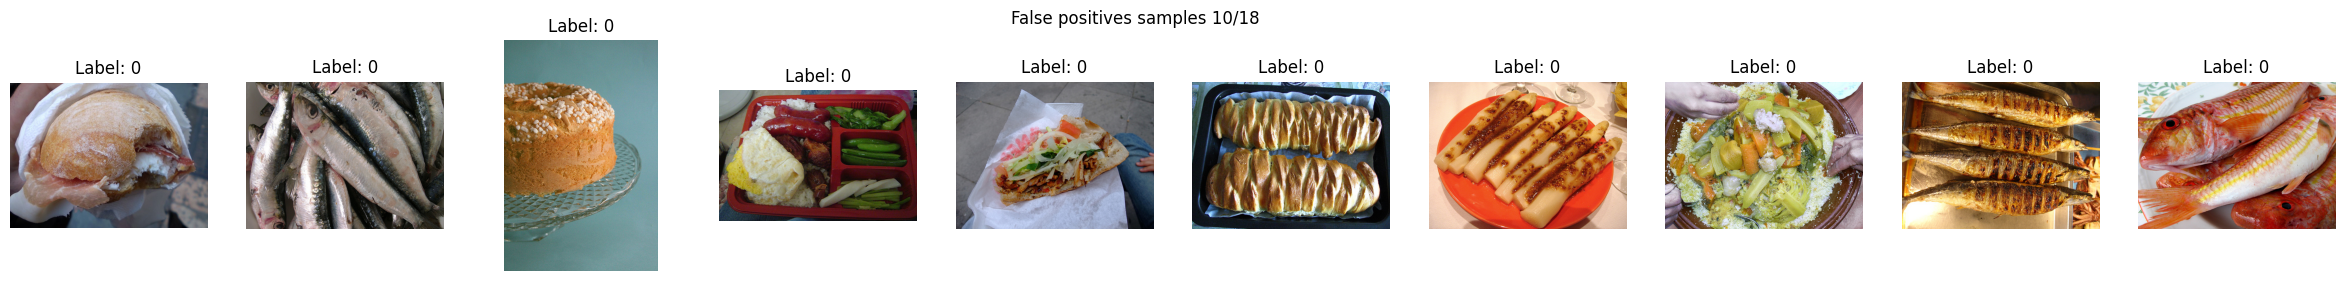

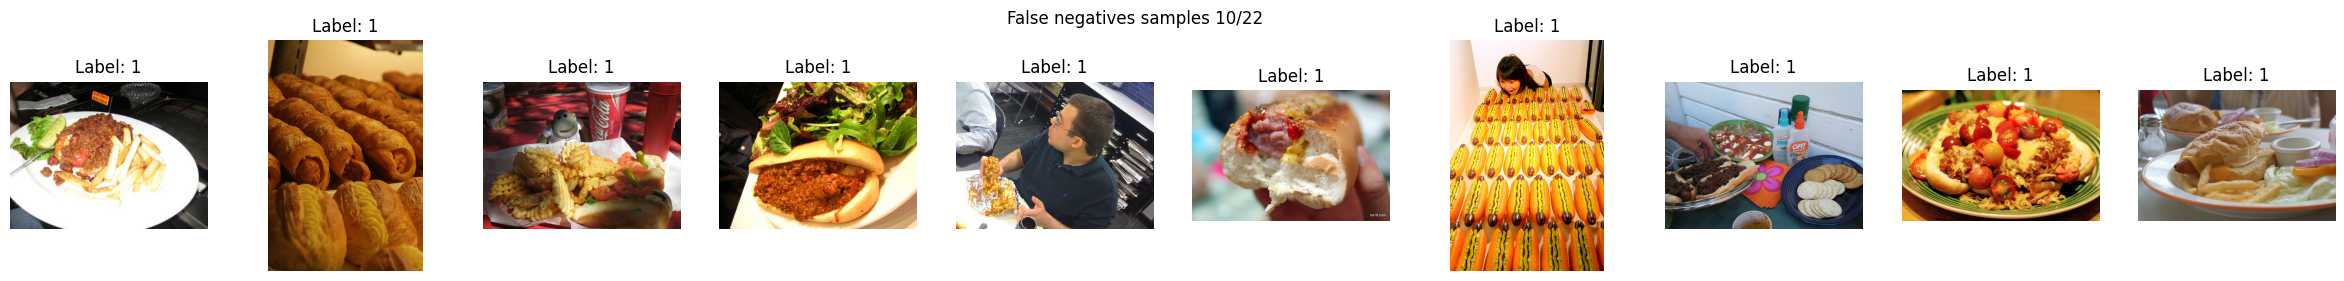

In [ ]:
false_positive_indices = [val_indices[i] for i in range(len(gt)) if predictions[i]==1 and gt[i]==0]
visualize_samples(orig_dataset, false_positive_indices, "False positives samples")

false_negatives_indices = [val_indices[i] for i in range(len(gt)) if predictions[i]==0 and gt[i]==1]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives samples")

print("Number of false-negative samples =", len(false_negatives_indices))
print("Number of false-positive samples =", len(false_positive_indices))

In [ ]:
def binary_classification_metrics(prediction, ground_truth):
    precision = precision_score(ground_truth, prediction)
    recall = recall_score(ground_truth, prediction)
    f1 = f1_score(ground_truth, prediction)
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.930, P: 0.936, R: 0.923


In [ ]:
image_id = []                                                                             # Preparing lists for writing to a file
predictions = []
model.eval()
for x,_,id_img in test_loader:
   x = x.to(device)
   prediction = best_model(x)
   _, indices = torch.max(prediction, 1)
   image_id.extend([f"{id_img}.jpg" for id_img in id_img])
   predictions.extend(indices.cpu().tolist())

In [ ]:
file_path = '/content/gdrive/MyDrive/hotdog_epochs/subm.csv'                               # That's all. Thank you for view. Goodbye))

with open(file_path, 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id, predictions))